# Решение одномерной акустической задачи сеточно-характеристическим методом с компактной схемой и кусочно-постоянными коэффициентами

In [1]:
# Импорт используемых модулей
import numpy as np
import matplotlib.pyplot as plt
from sympy import Matrix, symbols, init_printing
init_printing()

In [37]:
# Введём переменные расчёта
L = 2.0  # Длина материала в м
M = 141  # Количество узлов координат сетки
h = L / M # Шаг сетки по координате

c = 5/3  # Скорость звука в среде в м/с
rho = 2/5  # Плотность среды в кг/м^3 
# c2 = 0.9
# rho2 = 3/5
c2 = c
rho2 = rho / 100
# rho2 = 20/27  # Чтобы отражённой волны не было

T = 0.65 * L / c2
t = 0.4 * h / c  # Согласно критерию Куранта коэффициент должен быть меньше 1
N = int(T/t) * 2  # Количество шагов по времени
print(N)

p_current = np.zeros((N, M))
p_next = np.zeros((N, M))
v_current = np.zeros((N, M))
v_next = np.zeros((N, M))

458


In [38]:
# Введём новые переменные (инварианты Римана) 
w_1_current = np.zeros((N, M))
w_1_next = np.zeros((N, M))
w_2_current = np.zeros((N, M))
w_2_next = np.zeros((N, M))

# Создадим координатную сетку
x = [0] * M
for i in range(M):
    x[i] = i * h 

In [39]:
# Введём ещё переменные (производные инвариантов Римана по х)
nu_1_current = np.zeros((N, M))
nu_1_next = np.zeros((N, M))
nu_2_current = np.zeros((N, M))
nu_2_next = np.zeros((N, M))

In [40]:
def P_3_compact(u_current, u_next, nu_current, nu_next, i, j, lambd, t):
    if j == 0:
        a = (nu_current[i-1][j] + nu_current[i-1][M-1]) / h / h - 2.0 * (u_current[i-1][j] - u_current[i-1][M-1]) / h / h / h
        b = (2.0 * nu_current[i-1][j] + nu_current[i-1][M-1]) / h - 3.0 * (u_current[i-1][j] - u_current[i-1][M-1]) / h / h
    elif j == M-1:
        a = (nu_current[i-1][j] + nu_current[i-1][M-2]) / h / h - 2.0 * (u_current[i-1][j] - u_current[i-1][M-2]) / h / h / h
        b = (2.0 * nu_current[i-1][j] + nu_current[i-1][M-2]) / h - 3.0 * (u_current[i-1][j] - u_current[i-1][M-2]) / h / h
    else:
        a = (nu_current[i-1][j] + nu_current[i-1][j-1]) / h / h - 2.0 * (u_current[i-1][j] - u_current[i-1][j-1]) / h / h / h
        b = (2.0 * nu_current[i-1][j] + nu_current[i-1][j-1]) / h - 3.0 * (u_current[i-1][j] - u_current[i-1][j-1]) / h / h
    c = nu_current[i-1][j]
    d = u_current[i-1][j]
    
    x = (-1) * lambd * t
    u_next[i][j] = a * x * x * x + b * x * x + c * x + d
    nu_next[i][j] = 3.0 * a * x * x + 2.0 * b * x + c

    return u_next, nu_next

def P_3_compact_1(u_current, u_next, nu_current, nu_next, i, j, lambd, t):
    if j == 0:
        a = (nu_current[i-1][1] + nu_current[i-1][j]) / h / h - 2.0 * (u_current[i-1][1] - u_current[i-1][j]) / h / h / h
        b = ((-1) * (2.0 * nu_current[i-1][j] + nu_current[i-1][1])) / h - 3.0 * (u_current[i-1][j] - u_current[i-1][1]) / h / h
    elif j == M-1:
        a = (nu_current[i-1][0] + nu_current[i-1][j]) / h / h - 2.0 * (u_current[i-1][0] - u_current[i-1][j]) / h / h / h
        b = ((-1) * (2.0 * nu_current[i-1][j] + nu_current[i-1][0])) / h - 3.0 * (u_current[i-1][j] - u_current[i-1][0]) / h / h
    else:
        a = (nu_current[i-1][j+1] + nu_current[i-1][j]) / h / h - 2.0 * (u_current[i-1][j+1] - u_current[i-1][j]) / h / h / h
        b = ((-1) * (2.0 * nu_current[i-1][j] + nu_current[i-1][j+1])) / h - 3.0 * (u_current[i-1][j] - u_current[i-1][j+1]) / h / h
    c = nu_current[i-1][j]
    d = u_current[i-1][j]
    
    x = lambd * t
    u_next[i][j] = a * x * x * x + b * x * x + c * x + d
    nu_next[i][j] = 3.0 * a * x * x + 2.0 * b * x + c
   
    return u_next, nu_next

In [41]:
koeff = 2
# Initial conditions
for i in range((M-1)//koeff//16, (M-1)//koeff):
    v_current[0][i] = np.power(np.sin(i * koeff / (M-1) * np.pi), 4)
    p_current[0][i] = rho * c * v_current[0][i]
    
# Boundary conditions ...

for i in range(0, N-1):
    for j in range(1, M):
        # Переходим в инварианты Римана
        w_1_current[i][j] = (v_current[i][j] - p_current[i][j] / rho / c) / 2
        w_2_current[i][j] = (v_current[i][j] + p_current[i][j] / rho / c) / 2
        nu_1_current[i][j] = (4.0 * np.pi * np.power(np.sin(i * koeff / (M-1) * np.pi), 3) * np.cos(i * koeff / (M-1) * np.pi) * koeff / (M-1))*(1 - 1)
        nu_2_current[i][j] = (4.0 * np.pi * np.power(np.sin(i * koeff / (M-1) * np.pi), 3) * np.cos(i * koeff / (M-1) * np.pi) * koeff / (M-1))*(1 + 1)
        
        
        # Решаем уравнения переноса компактной схемой
        if j < M//2:
            w_2_next, nu_2_next = P_3_compact(w_2_current, w_2_next, nu_2_current, nu_2_next, i, j, c, t)
            w_1_next, nu_1_next = P_3_compact_1(w_1_current, w_1_next, nu_1_current, nu_1_next, i, j, c, t)
        if j > M//2:
            w_2_next, nu_2_next = P_3_compact(w_2_current, w_2_next, nu_2_current, nu_2_next, i, j, c2, t)
            w_1_next, nu_1_next = P_3_compact_1(w_1_current, w_1_next, nu_1_current, nu_1_next, i, j, c2, t)
        if j == M//2:
            w_2_next, nu_2_next = P_3_compact(w_2_current, w_2_next, nu_2_current, nu_2_next, i, j, c, t)
            w_1_next, nu_1_next = P_3_compact_1(w_1_current, w_1_next, nu_1_current, nu_1_next, i, j, c2, t)

        # Переходим в исходные координаты
        if (j < M//2) and (j > 0):
            v_next[i][j] = w_1_next[i][j] + w_2_next[i][j] 
            p_next[i][j] = (w_2_next[i][j] - w_1_next[i][j]) * rho * c
        if j > M//2:
            p_next[i][j] = (-1) * (w_1_next[i][j] - w_2_next[i][j]) * rho2*c2 
            v_next[i][j] = (w_1_next[i][j] + w_2_next[i][j])    
        if j == M//2:    
            p_next[i][j] = (-1) * 2.0 * (w_1_next[i][j] - w_2_next[i][j]) * rho2*rho*c2*c / (c * rho + c2 * rho2)
            v_next[i][j] = 2.0 * (c * rho * w_1_next[i][j] + c2 * rho2 * w_2_next[i][j]) / (c * rho + c2 * rho2)       
        
        p_current[i+1][j] = p_next[i][j]
        v_current[i+1][j] = v_next[i][j]

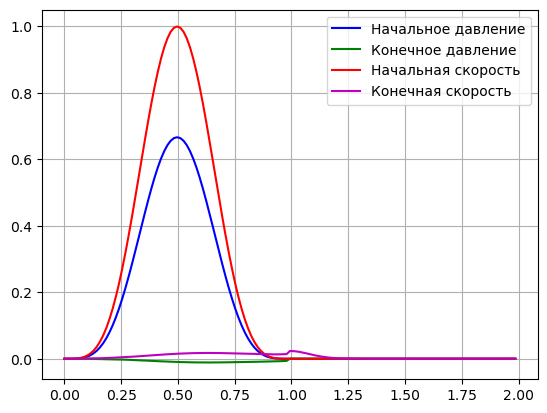

In [42]:
plt.plot(x, [p_current[0][i] for i in range(M)], color="b", label="Начальное давление")
plt.plot(x, [p_current[420][i] for i in range(M)], color="g",  label="Конечное давление")
plt.plot(x, [v_current[0][i] for i in range(M)], color="r", label="Начальная скорость")
plt.plot(x, [v_current[420][i] for i in range(M)], color="m", label="Конечная скорость")
plt.legend()
plt.grid(True)
plt.show()